# Messying Around with sklearn classifiers with 2 input features
This notebook is not at all professional, just a means to learn and get comfortable with some libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions 

In [ ]:
from sklearn.model_selection import GridSearchCV

def optimize(clf, param_grid, x_train, y_train):
    grid_search = GridSearchCV(clf, param_grid, scoring='neg_root_mean_squared_error')
    grid_search.fit(x_train, y_train)
    # set best params to clf
    for name, value in grid_search.best_params_.items():
        clf.set_params(**{name: value})
    return grid_search.best_params_, grid_search.best_score_
    
def show_regions(clf, X, y):
    fig = plt.figure(figsize=(8,6))
    plot_decision_regions(X=np.array(X), y=y, clf=clf, legend=2, ax=plt.gca())
    plt.show()

# Softmax  

## Iris

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data, iris.target
df = pd.DataFrame(data=X, columns=iris.feature_names)
df.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


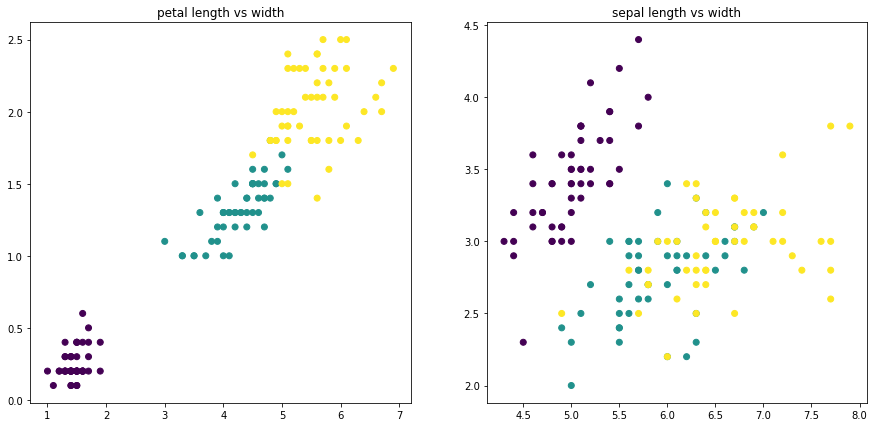

In [ ]:

figure, axis = plt.subplots(1, 2)
axis[0].scatter(x=df['petal length (cm)'], y=df['petal width (cm)'], c=y)
axis[0].set_title('petal length vs width')
axis[1].scatter(x=df['sepal length (cm)'], y=df['sepal width (cm)'], c=y)
axis[1].set_title('sepal length vs width')

figure.set_size_inches(15,7)
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df[['petal length (cm)', 'petal width (cm)']]), y, test_size=0.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# random state for reproducability
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', log_reg)
])

# Optimizing and messing with hyper params
# (although has little effect)
log_reg_param_grid = [
    {
        'log_reg__solver': ['lbfgs', 'newton-cg'],
        'log_reg__C': [0.1, 0.2, 0.3, 0.5, 1],
        'log_reg__penalty': ['l2']
    },
    {
        'log_reg__solver': ['liblinear'],
        'log_reg__C': [0.1, 0.2, 0.3, 0.5, 1],
        'log_reg__penalty': ['l1', 'l2']
    },
    {
        'log_reg__solver': ['saga'],
        'log_reg__l1_ratio': [0, 0.2, 0.5, 0.7, 1],
        'log_reg__C': [0.1, 0.2, 0.3, 0.5, 1],
        'log_reg__penalty': ['elasticnet']
    }
]

In [ ]:
optimize(log_reg_pipe, log_reg_param_grid, x_train, y_train)

({'log_reg__C': 0.2, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'},
 -0.09855985596534887)

In [ ]:
log_reg_pipe.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.2, max_iter=500, random_state=42))])

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


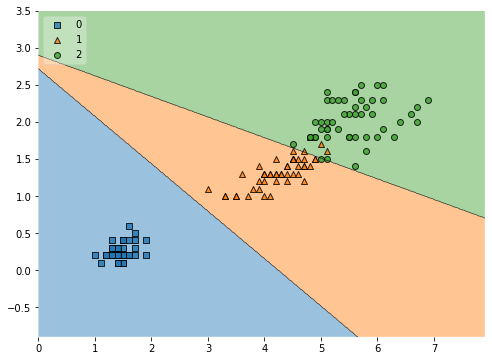

In [ ]:
X = df[['petal length (cm)', 'petal width (cm)']]
show_regions(log_reg_pipe, X, y)

In [ ]:
joblib.dump(log_reg_pipe, 'softmax.joblib')

['softmax.joblib']

# SVM 

## Penguins

In [ ]:
import seaborn as sns
df = sns.load_dataset('penguins')
df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female


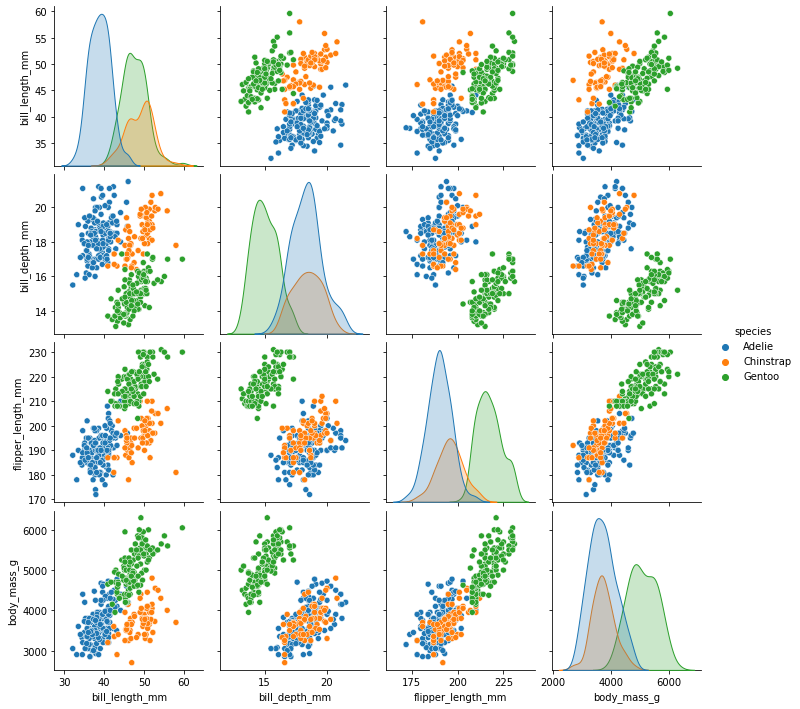

In [ ]:
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

df.dropna(inplace=True)

y = df['species']
lab_enc = LabelEncoder()
lab_enc.fit(y)
y = lab_enc.transform(y)

sns.pairplot(df, hue='species')

In [ ]:
X = df[['bill_length_mm', 'body_mass_g']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

svc = SVC(random_state=42, max_iter=20_000)
svc_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('svc', svc)
])

svc_param_grid = [
    {
        'svc__kernel': ['poly'],
        'svc__degree': [1, 2, 3, 4, 10]
    },
    {
        'svc__kernel': ['rbf', 'sigmoid'],
        'svc__gamma': [0.1, 0.5, 1, 5, 10, 20],
        'svc__C': [0.1, 0.2, 0.5, 1, 5, 10, 20]
    }
]

In [ ]:
optimize(svc_pipe, svc_param_grid, x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider

({'svc__C': 20, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'},
 -0.37234092157167986)

In [ ]:
svc_pipe.fit(x_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('svc',
                 SVC(C=20, gamma=0.1, kernel='sigmoid', max_iter=20000,
                     random_state=42))])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


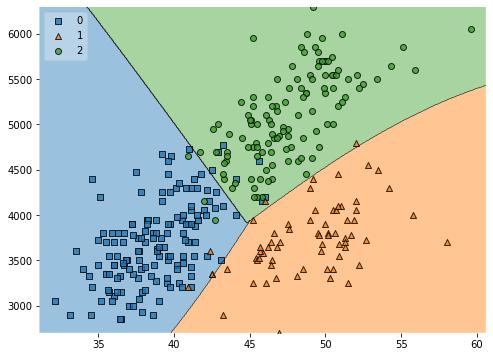

In [ ]:
show_regions(svc_pipe, X, y)

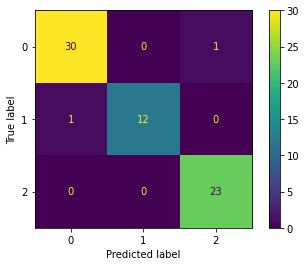

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = svc_pipe.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Generated Datasets

In [ ]:
from sklearn.datasets import make_blobs

svc = SVC(random_state=42, max_iter=20_000)

''' warning -> this code takes about 3 minutes
fig, axes = plt.subplots(3, 4)
fig.set_size_inches(20,15)
np.random.seed(0)

for i, axe in enumerate(axes):
    for subplot in axe:
        X, y = make_blobs(
            n_samples=300, 
            n_features=2,
            centers=(np.random.rand(2+i,2)*5),
            cluster_std= 0.5, 
            random_state=2
        )
        svc.fit(X, y)
        plot_decision_regions(X=np.array(X), y=y, clf=svc, legend=2, ax=subplot) 

plt.show()  '''

' fig, axes = plt.subplots(3, 4)\nfig.set_size_inches(20,15)\nnp.random.seed(0)\n\nfor i, axe in enumerate(axes):\n    for subplot in axe:\n        X, y = make_blobs(\n            n_samples=300, \n            n_features=2,\n            centers=(np.random.rand(2+i,2)*5),\n            cluster_std= 0.5, \n            random_state=2\n        )\n        svc.fit(X, y)\n        plot_decision_regions(X=np.array(X), y=y, clf=svc, legend=2, ax=subplot) \n\nplt.show()  '

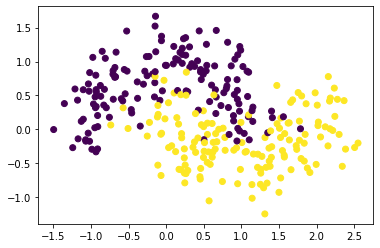

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.3)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [ ]:
svc = SVC(random_state=42, max_iter=20_000, probability=True)
svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svc)
])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
optimize(svc_pipe, svc_param_grid, x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider

({'svc__C': 5, 'svc__gamma': 1, 'svc__kernel': 'rbf'}, -0.2701127103178972)

In [ ]:
svc_pipe.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=5, gamma=1, max_iter=20000, probability=True,
                     random_state=42))])

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


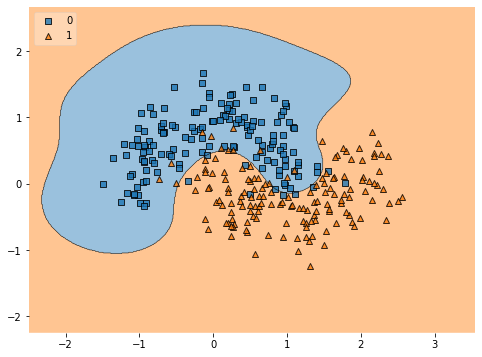

In [ ]:
show_regions(svc_pipe, X, y)

In [ ]:
svc_pipe.score(x_test, y_test)

0.88

In [ ]:
joblib.dump(svc_pipe, 'svc.joblib')

['svc.joblib']

In [ ]:
svc_pipe.predict_log_proba([[1,1]])

array([[-0.08365929, -2.52254081]])

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_param_grid = [{
    'max_depth': [None, 1, 2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 5],
}]
optimize(rf, rf_param_grid, x_train, y_train) # still using make moons

({'max_depth': None, 'min_samples_leaf': 1}, -0.2894427190999916)

In [ ]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


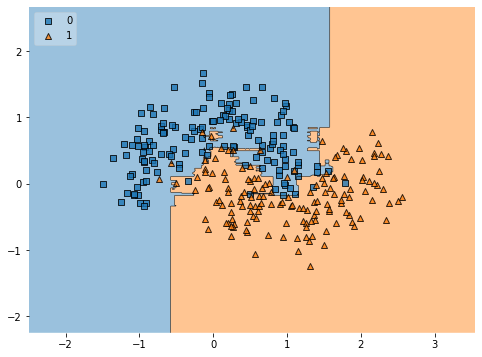

In [ ]:
show_regions(rf, X, y)

In [ ]:
joblib.dump(rf, 'random_forest.joblib')

['random_forest.joblib']